# Analyse BART model for extracting persona sentences from a dialogue segment

This notebook is meant for analysis and visualization of the results of evaluating the BART model for persona extraction.
The first part of the notebook lists available files in the folder with evaluation results. Use an appropriate filter to load the desired file(s) to analyze.

The analysis uses two types of files as input:
- files ending with '_stats.txt' contain aggregated metrics for an evaluation run as a whole
- files ending with '_evalresults.txt' contain statistics about each sample in the test dataset


In [1]:
from dataset.msc_summary_turns import MSC_Turns
from dataset.msc_summary import MSC_Summaries
from dataset.msc_summary import plot_heatmaps
import json
import pandas as pd
import numpy as np
import itertools
import os
import math
from ast import literal_eval
import matplotlib.pyplot as plt

In [2]:
prepfile = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_dialogue/preprocessed:trained_base_reweighted_bart:session_4_test.json"
with open(prepfile) as f:
    d = json.loads(f.read())
print(len(d))

501


## Load dataset, stats and evalresults

In [3]:
# List the available files in the eval_results directory

eval_results_dir = "/Users/FrankVerhoef/Programming/PEX/output/eval_results/"
files = sorted([item.path for item in os.scandir(eval_results_dir) if not item.is_dir()])
files

['/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_120957_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121242_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_121619_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_evalresults.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eval_results/trained2_base_reweighted_bart_20230628_122031_stats.txt',
 '/Users/FrankVerhoef/Programming/PEX/output/eva

In [4]:
# Collect results in dicts
stats_list = []
evalresults_dict = {}
config_list = []

# Load list with ALL trial_names
trial_names = list(set([
    '_'.join((f.split('/')[-1].split('_')[:-1]))
    for f in files
]))

#
# IF NECESSARY: USE ONLY SELF SELECTED FILES
#

# Trials for SUMMARY GENERATION

selection_fn = lambda s: \
    (s.find('trained_nll05_bart_202308') >= 0) or \
    (s.find('trained_nll05_bart_20230722') >= 0 and \
     s.find('trained_nll05_bart_20230722_00') == -1)  # FINAL RUN with 40 eval runs with for sessions 1-4, with 9 different generation configs

# Trials for FACT EXTRACTION
selection_fn = lambda s: s.find('trained_nll05_bart_20230723') >= 0 # FINAL RUN 

## older runs for evaluation of fact extraction
# trial_names = [
#     'trained_nll05_bart_20230715_191928', 
#     'trained_nll05_bart_20230716_012913', 
#     'trained_nll05_bart_20230715_213740', 
#     'trained_rw05_bart_20230715_190156', 
#     'trained_rw05_bart_20230715_213435'
# ]


trial_names = sorted([f for f in trial_names if selection_fn(f)])

print(f"SELECTED TRIALS ({len(trial_names)}")
print('\n'.join(trial_names))

for trial_name in trial_names:

    # Load the '_stats' file. This contains two dicts:
    # first dict contains the aggregated statistics
    # second dict contains the configuration setting for the run
    with open(f"{eval_results_dir}{trial_name}_stats.txt") as f:
        data = f.read().replace('\n', '')
        stats = json.loads(data.split('}{')[0] + '}')
        stats["trial_name"] = trial_name
        stats["date"] = '_'.join(trial_name.split('_')[-2:])
        config = json.loads('{' + data.split('}{')[1])
        config["trial_name"] = trial_name
        stats_list.append(stats)
        config_list.append(config)

    # Load the '_evalstats' file. This contains two dicts:
    # first dict contains the testresults per sample
    # second dict contains the configuration setting for the run
    with open(f"{eval_results_dir}{trial_name}_evalresults.txt") as f:
        data = f.read().replace('\n', '')
        evalresults = json.loads(data.split('}{')[0] + '}')
        evalresults = {literal_eval(k): v for k, v in evalresults.items()}
        for k in evalresults.keys():
            evalresults[k]['trial_name'] = trial_name
        evalresults_dict[trial_name] = evalresults
    
# stats_dict[trial_names[0]]
print(len(stats_list), len(evalresults_dict), len(config_list))

SELECTED TRIALS (1
trained_nll05_bart_20230723_163659
1 1 1


In [5]:
# Convert list with stats and configs to dataframe

all_stats_df = pd.DataFrame.from_dict(stats_list)
all_stats_df = all_stats_df.set_index("trial_name")
all_config_df = pd.DataFrame(config_list)
all_config_df = all_config_df.set_index("trial_name")

In [6]:
# Combine stats with config

all_stats_df = all_stats_df.join(all_config_df, validate="1:1")
all_stats_df

,test_loss,test_classification_loss,test_lm_loss,test_acc,test_perplexity,test_token_prediction_acc,eval_acc,eval_f1,eval_precision,eval_recall,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230723_163659,1.078764,0.824534,1.078764,0.8406,4.264922,0.660646,0.843324,0.883759,0.900149,0.867956,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


In [7]:
all_config_df

,configfile,seed,checkpoint_dir,output_dir,log_interval,loglevel,logdir,load,save,device,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
trial_name,,,,,,,,,,,,,,,,,,,,,
trained_nll05_bart_20230723_163659,None,42,./checkpoints/,./output/,10,VERBOSE,/scratch-local/frankv.3126271/logs/,trained_nll05_bart,,cuda,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


In [8]:
# Convert eval_results to DataFrame and combine with config

eval_results_df = pd.concat([
    pd.DataFrame.from_records(list(evalresults_dict[trial_name].values()))
    for trial_name in evalresults_dict.keys()
])
eval_results_df = eval_results_df.join(all_config_df, on='trial_name')
eval_results_df.head()

,convai_id,pred_fact,target_fact,nli_pred,nli_target,nli_pred_to_target,nli_target_to_pred,pred_persona,target_persona,numwords_factor,...,test_samples,java_home,terpdir,tmpdir,nli_model,speaker_prefixes,nofact_token,add_tokens,len_context,sessions
0,test_0,1,1,0.996926,0.994330,0.384658,0.994105,I don't own a car. I live in a small town. I e...,I live semi-close towkr. I don't own a car. I ...,0.800000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
1,test_0,1,1,0.951207,0.984040,0.011001,0.997741,I go to the gym to work out.,I enjoy exercising at the gym.,1.333333,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
2,test_0,1,1,0.990445,0.979994,0.998073,0.997944,I am a computer programmer.,I'm a computer programmer.,1.250000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
3,test_0,1,1,0.894218,0.972481,0.998901,0.998873,I work in marketing.,I have a marketing job.,0.800000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"
4,test_0,1,1,0.909492,0.977780,0.001790,0.491099,I love meat.,I like grilling steak.,0.750000,...,None,/sw/arch/RHEL8/EB_production/2022/software/Jav...,/home/frankv/terp/,/scratch-local/frankv.3126271/,facebook/bart-large-mnli,"[<other>, <self>]",,None,2,"[1, 2, 3, 4]"


## Analysis of persona extraction

### Collect evalresults in Dataframe

In [9]:
# Load the MSC_Turns dataset

basedir = "/Users/FrankVerhoef/Programming/PEX/data/msc/msc_personasummary/"
sessions = [1, 2, 3, 4]
subset = 'test'
msc_turns = MSC_Turns(basedir=basedir, sessions=sessions, subset=subset)

In [10]:
# PICK ONE OF THE LOADED TRIALS FOR ANALYSIS OF RESULTS

# evalresults = evalresults_dict["trained_nll05_bart_20230715_213740"]
evalresults = evalresults_dict["trained_nll05_bart_20230723_163659"]  # The 'Final' run

keys = pd.MultiIndex.from_tuples(evalresults.keys())
keys
values = list(evalresults.values())
df = pd.DataFrame.from_records(values, index=keys)
print("Number of samples in this trial: ", len(df))
df.head()

Number of samples in this trial:  22371


convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0 0    test_0          1            1  0.996926    0.994330   
    1    test_0          1            1  0.951207    0.984040   
    2    test_0          1            1  0.990445    0.979994   
    3    test_0          1            1  0.894218    0.972481   
    4    test_0          1            1  0.909492    0.977780   

       nli_pred_to_target  nli_target_to_pred  \
1 0 0            0.384658            0.994105   
    1            0.011001            0.997741   
    2            0.998073            0.997944   
    3            0.998901            0.998873   
    4            0.001790            0.491099   

                                            pred_persona  \
1 0 0  I don't own a car. I live in a small town. I e...   
    1                       I go to the gym to work out.   
    2                        I am a computer programmer.   
    3                               I work in marketing.   
    4                                       I love meat.   

                                          target_persona  numwords_factor  \
1 0 0  I live semi-close towkr. I don't own a car. I ...         0.800000   
    1                     I enjoy exercising at the gym.         1.333333   
    2                         I'm a computer programmer.         1.250000   
    3                            I have a marketing job.         0.800000   
    4                             I like grilling steak.         0.750000   

       len_p_split  len_t_split      terp  \
1 0 0          3.0          4.0  0.437776   
    1          1.0          1.0  0.598979   
    2          1.0          1.0  0.363080   
    3          1.0          1.0  0.756672   
    4          1.0          1.0  0.631376   

                                              terpscores    terpf1  \
1 0 0  [[1.0, 0.9077003002166748, 1.0], [0.0, 0.98569...  0.857143   
    1                             [[0.6988091468811035]]  1.000000   
    2                             [[0.4538501501083374]]  1.000000   
    3                             [[0.9080064296722412]]  0.000000   
    4                             [[0.7892205119132996]]  0.000000   

       terpprecision  terprecall                          trial_name  
1 0 0            1.0        0.75  trained_nll05_bart_20230723_163659  
    1            1.0        1.00  trained_nll05_bart_20230723_163659  
    2            1.0        1.00  trained_nll05_bart_20230723_163659  
    3            0.0        0.00  trained_nll05_bart_20230723_163659  
    4            0.0        0.00  trained_nll05_bart_20230723_163659

In [11]:
###
### Add the item measurements to the dataframe
###

m = msc_turns.measurements()['allitem_measurements']
df_m = pd.DataFrame.from_records(m)
df_m.index = pd.MultiIndex.from_arrays(df_m[['session', 'dialog_id', 'turn_id']].values.T)
df_m = df_m.drop(['convai_id'], axis=1)
df = df.join(df_m, how='inner')

# Add length of prediction
def get_length(sentence):
    l = len(sentence.split())
    return l

df['predictionwords'] = df['pred_persona'].apply(lambda x: get_length(x))
df.columns


Index(['convai_id', 'pred_fact', 'target_fact', 'nli_pred', 'nli_target',
       'nli_pred_to_target', 'nli_target_to_pred', 'pred_persona',
       'target_persona', 'numwords_factor', 'len_p_split', 'len_t_split',
       'terp', 'terpscores', 'terpf1', 'terpprecision', 'terprecall',
       'trial_name', 'session', 'dialog_id', 'turn_id', 'inputwords',
       'labelwords', 'predictionwords'],
      dtype='object')

In [12]:
###
### Add the input sentence from dataset to the dataframe
###

df['history'] = [msc_turns[i][0].replace('\n', '<sep>') for i in range(len(msc_turns))]
df

convai_id  pred_fact  target_fact  nli_pred  nli_target  \
1 0   0      test_0          1            1  0.996926    0.994330   
      1      test_0          1            1  0.951207    0.984040   
      2      test_0          1            1  0.990445    0.979994   
      3      test_0          1            1  0.894218    0.972481   
      4      test_0          1            1  0.909492    0.977780   
...             ...        ...          ...       ...         ...   
4 500 6   test_1014          1            1  0.989097    0.993115   
      7   test_1014          0            0       NaN         NaN   
      8   test_1014          0            0       NaN         NaN   
      9   test_1014          1            1  0.951873    0.950607   
      10  test_1014          0            0       NaN         NaN   

          nli_pred_to_target  nli_target_to_pred  \
1 0   0             0.384658            0.994105   
      1             0.011001            0.997741   
      2             0.998073            0.997944   
      3             0.998901            0.998873   
      4             0.001790            0.491099   
...                      ...                 ...   
4 500 6             0.995964            0.576474   
      7                  NaN                 NaN   
      8                  NaN                 NaN   
      9             0.000857            0.990895   
      10                 NaN                 NaN   

                                               pred_persona  \
1 0   0   I don't own a car. I live in a small town. I e...   
      1                        I go to the gym to work out.   
      2                         I am a computer programmer.   
      3                                I work in marketing.   
      4                                        I love meat.   
...                                                     ...   
4 500 6                         I have visited Denver once.   
      7                                                       
      8                                                       
      9                                    I have a family.   
      10                                                      

                                             target_persona  numwords_factor  \
1 0   0   I live semi-close towkr. I don't own a car. I ...         0.800000   
      1                      I enjoy exercising at the gym.         1.333333   
      2                          I'm a computer programmer.         1.250000   
      3                             I have a marketing job.         0.800000   
      4                              I like grilling steak.         0.750000   
...                                                     ...              ...   
4 500 6                              I have visited Denver.         1.250000   
      7                                                                  NaN   
      8                                                                  NaN   
      9              I will be doing a hike with my family.         0.444444   
      10                                                                 NaN   

          ...  terpprecision  terprecall                          trial_name  \
1 0   0   ...            1.0        0.75  trained_nll05_bart_20230723_163659   
      1   ...            1.0        1.00  trained_nll05_bart_20230723_163659   
      2   ...            1.0        1.00  trained_nll05_bart_20230723_163659   
      3   ...            0.0        0.00  trained_nll05_bart_20230723_163659   
      4   ...            0.0        0.00  trained_nll05_bart_20230723_163659   
...       ...            ...         ...                                 ...   
4 500 6   ...            1.0        1.00  trained_nll05_bart_20230723_163659   
      7   ...            NaN         NaN  trained_nll05_bart_20230723_163659   
      8   ...            NaN         NaN  trained_nll05_bart_20230723_163659   
      9   ...            0.0        0.

### Length

In [13]:
selection = (df['target_persona'] != '') & (df['session'] != 1)
print(df[selection].groupby(['session'])['labelwords'].mean())
print(df[selection]['labelwords'].mean())

selection = (df['pred_persona'] != '') &(df['session'] != 1)
print(df[selection].groupby(['session'])['predictionwords'].mean())
print(df[selection]['predictionwords'].mean())

session
2     9.747765
3    10.315015
4    10.328499
Name: labelwords, dtype: float64
10.133412800293417
session
2    6.644969
3    6.521505
4    6.593185
Name: predictionwords, dtype: float64
6.587540279269603


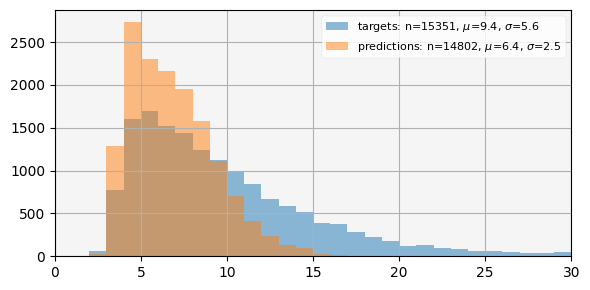

In [14]:
# Average length of ALL samples in the trial

fig, ax=plt.subplots(figsize=(6,3))
bins=np.linspace(0, 30, 31)

selectors = ['target_fact', 'pred_fact']
columns = ['labelwords', 'predictionwords']
labels = ['targets', 'predictions']

with plt.style.context('seaborn-v0_8-paper'):
    for selector, col, label in zip(selectors, columns, labels):
        data = df[df[selector] == 1][col]
        df[df[selector] == 1].hist(column=col, bins=bins, ax=ax, alpha=0.5, label=f"{label}: n={data.count()}, $\mu$={data.mean():.1f}, $\sigma$={data.std():.1f}")

    ax.set_facecolor('whitesmoke')
    ax.set_title('')
    ax.set_xlim(0,30)
    ax.legend()
    fig.tight_layout()

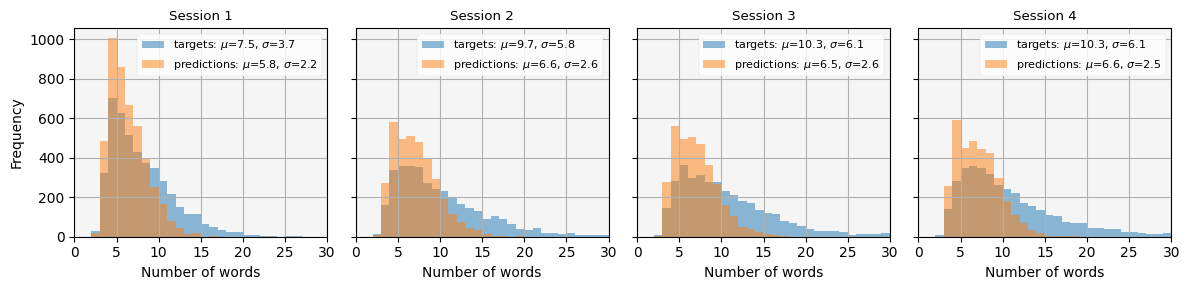

In [15]:
### ***THESIS*** Figure 4.6

# Average length of predictions and targets, per session

fig, axs=plt.subplots(ncols=4, figsize=(12,3), sharey=True)
bins=np.linspace(0, 30, 31)

selectors = ['target_fact', 'pred_fact']
columns = ['labelwords', 'predictionwords']
labels = ['targets', 'predictions']

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip([1, 2, 3, 4], axs):
        selection = df['session'] == session
        for selector, col, label in zip(selectors, columns, labels):
            data = df[selection & (df[selector] == 1)][col]
            df[selection & (df[selector] == 1)].hist(column=col, bins=bins, ax=ax, alpha=0.5, label=f"{label}: $\mu$={data.mean():.1f}, $\sigma$={data.std():.1f}")

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"Session {session}")
        ax.set_xlim(0,30)
        ax.set_xlabel("Number of words")
        ax.legend()
        if session == 1:
            ax.set_ylabel("Frequency")

    fig.tight_layout()
plt.savefig('../docs/msc_turns_length.pdf', dpi=300, format='pdf', bbox_inches='tight')

### Classification

Text(0.5, 0.98, 'Accuracy of predicted facts, per session')

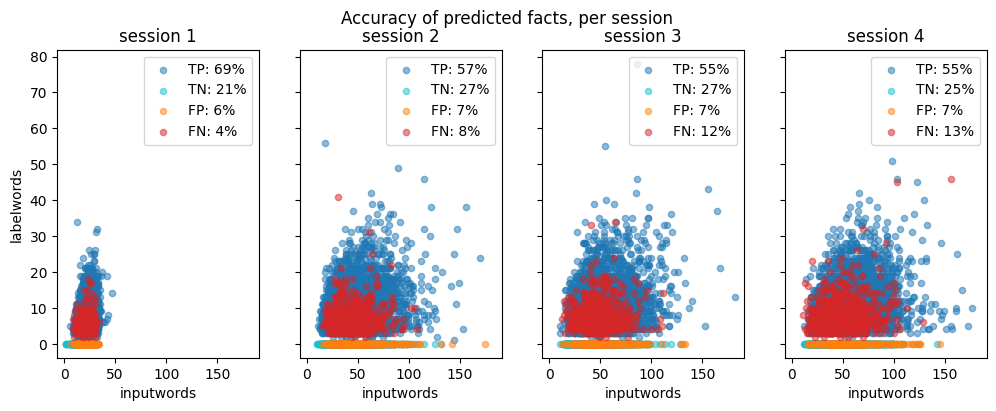

In [16]:
sessions = df['session'].unique()
fig, ax = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True, sharex=True)


selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
for i, session in enumerate(sessions):
    selected_session = df['session'] == session
    total = len(df[selected_session])
    for s in selection.keys():
        count = len(df[selected_session & selection[s]])
        label = f"{s}: {count/total:.0%}"
        df[selected_session & selection[s]].plot.scatter('inputwords', 'labelwords', c=col[s], alpha=0.5, label=label, ax=ax[i])
    ax[i].set_title(f"session {session}")

fig.suptitle("Accuracy of predicted facts, per session")

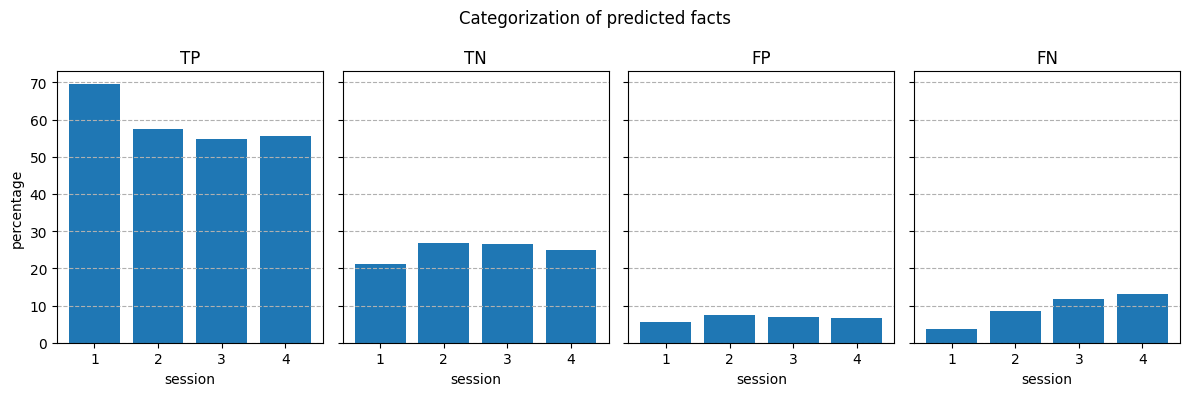

In [17]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(ncols=len(selection.keys()), figsize=(12,4), sharey=True, sharex=True)

session_total = df.groupby(['session'])['turn_id'].count().values

for i, s in enumerate(selection.keys()):
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count()
    perc = category_count / session_total * 100
    ax[i].bar(x=sessions, height=perc)
    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(s)
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.tight_layout()

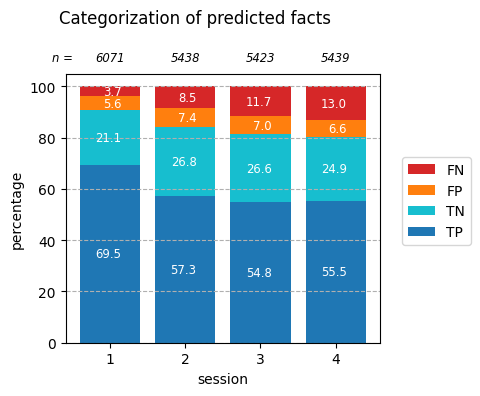

In [18]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
fig, ax = plt.subplots(figsize=(4,4))

session_total = df.groupby(['session'])['turn_id'].count().values
bottom = np.zeros(len(selection.keys()))

for s in selection.keys():
    category_count = df[selection[s]].groupby(['session'])['turn_id'].count().values
    perc = category_count / session_total * 100
    ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
    for session, b, p in zip(sessions, bottom, perc):
        ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', c='w')
    bottom += perc

ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, session_total):
    ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts")
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

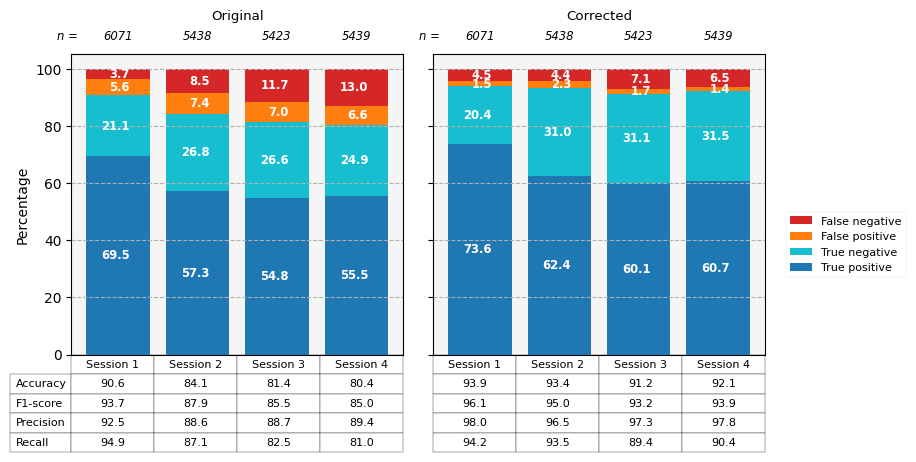

In [19]:
### ***THESIS*** Figure 4.5

sessions = df['session'].unique()

# Below are the findings from review of a sample of 344 predictions. 
# These were checked to confirm if the annotated facts were indeed correct, but also if dialogues where no fact was annotated was correct
# This leads to a correction of the TP, TN, FP, FN categories.capitalize
# The array below is ordered per session, original label (TP, TN, FP, FN), revised label (TP, TN, FP, FN)
# For example, for session 3, there are 16 FP's that are in fact TP, and 5 FP's are correctly labeled as FP.
review = np.array([
    [[27, 0, 0, 0],
     [0, 19, 0, 1],
     [8, 0, 3, 0],
     [0, 1, 0, 13]],
    [[15, 0, 0, 0], 
     [0, 27, 0, 1],
     [20, 0, 9, 0],
     [0, 12, 0, 8]],
    [[24, 0, 0, 0],
     [0, 17, 0, 0],
     [16, 0, 5, 0],
     [0, 7, 0, 11]],
    [[24, 0, 0, 0],
     [0, 23, 0, 2],
     [15, 0, 4, 0],
     [0, 21, 0, 11]],
])
correction_matrix = np.array([
    review[s] / review[s].sum(axis=1).reshape(-1, 1)
    for s in range(4)
])

selection = {}
selection["True positive"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["True negative"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["False positive"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["False negative"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "True positive": 'tab:blue',
    "True negative": 'tab:cyan',
    "False positive": 'tab:orange',
    "False negative": 'tab:red'
}


session_total = df.groupby(['session'])['turn_id'].count().values
original_counts = np.array([
    df[selection[s]].groupby(['session'])['turn_id'].count().values
    for s in selection.keys()
])
corrected_counts = np.array([
    original_counts[:,s] @ correction_matrix[s]
    for s in range(4)
]).T

chart_data = np.array([original_counts, corrected_counts])
titles = ["Original", "Corrected"]

fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True)
with plt.style.context('seaborn-v0_8-paper'):
    for dataset, ax in zip(range(2), axs):

        bottom = np.zeros(len(selection.keys()))
        for i, s in enumerate(selection.keys()):
            perc = chart_data[dataset][i] / session_total * 100
            ax.bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
            for session, b, p in zip(sessions, bottom, perc):
                ax.text(session + 0.15, b + p/2, f"{p:.1f}", horizontalalignment='right', verticalalignment='center', fontsize='small', fontweight='bold', c='w')
            bottom += perc


        # Plot a table with Accuracy, F1, Precision, Recall
        acc = (chart_data[dataset][0] + chart_data[dataset][1]) / sum(chart_data[dataset])
        prec = chart_data[dataset][0] / (chart_data[dataset][0] + chart_data[dataset][2])
        rec = chart_data[dataset][0] / (chart_data[dataset][0] + chart_data[dataset][3])
        f1 = [(2 * p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(prec, rec)]
        ax_table = ax.table(
            cellText=np.round(np.array([acc, f1, prec, rec]) * 100, 1),
            colLabels=[f"Session {s}" for s in sessions],
            rowLabels=["Accuracy", "F1-score", "Precision", "Recall"] if dataset == 0 else None,
            cellLoc='center',
            loc='bottom',
        )
        ax_table.scale(1, 1.5)
        # ax_table.auto_set_font_size(False)
        # ax_table.set_fontsize(10)

        ax.set_facecolor('whitesmoke')
        ax.set_title(titles[dataset], pad=25)
        ax.text(0.5, 110, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        for session, t in zip(sessions, session_total):
            ax.text(session, 110, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
        ax.grid(which='major', axis='y', linestyle='--')
        # ax.set_xticks(sessions)
        # ax.set_xlabel("Session")
        ax.set_xticks([])
        if dataset == 0:
            ax.set_ylabel("Percentage")

    # fig.suptitle("Categorization of predicted facts")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)

    fig.tight_layout()
    plt.savefig('../docs/msc_turns_accuracy.pdf', dpi=300, format='pdf', bbox_inches='tight')

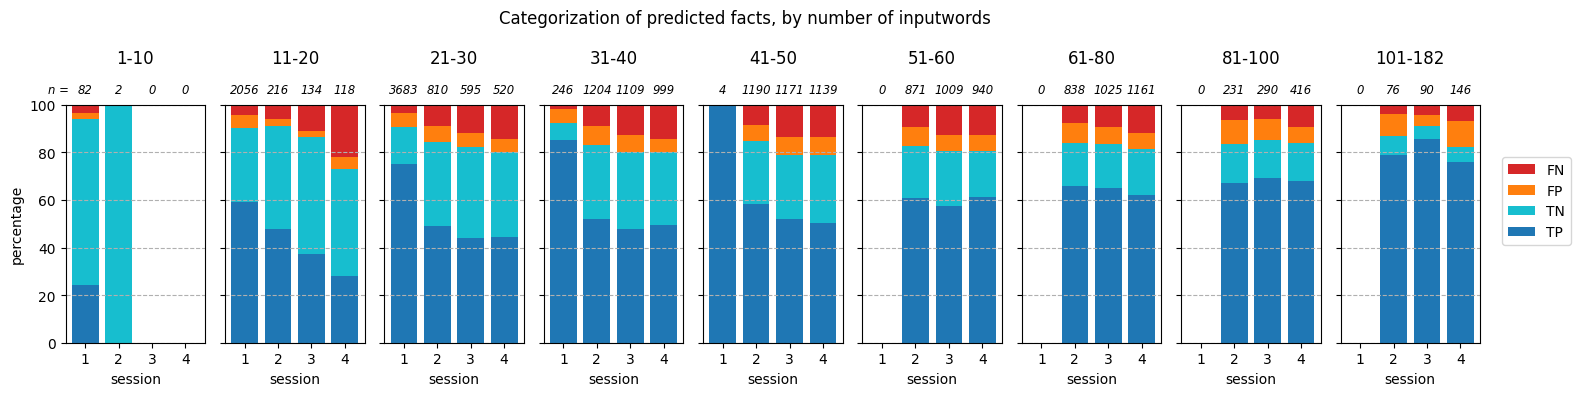

In [20]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
col = {
    "TP": 'tab:blue',
    "TN": 'tab:cyan',
    "FP": 'tab:orange',
    "FN": 'tab:red'
}
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
# bin_boundaries = [0, 20, 40, 200]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, ax = plt.subplots(ncols=len(bins), figsize=(15, 4), sharey=True)


for i, (lower, upper) in enumerate(bins):
    selected_bin = (df['inputwords'] >= lower) & (df['inputwords'] <= upper)
    session_total = np.array([len(df[selected_bin & (df['session'] == session)]) for session in sessions])
    # print("Session total: ", session_total)
    bottom = np.zeros(len(selection.keys()))

    for s in selection.keys():
        category_count = np.array([len(df[selected_bin & selection[s] & (df['session'] == session)]) for session in sessions])
        # print("Category count: ", category_count)
        perc = category_count / np.maximum(session_total, np.ones_like(session_total)) * 100
        ax[i].bar(x=sessions, height=perc, bottom=bottom, color=col[s], label=s)
        bottom += perc

    ax[i].grid(which='major', axis='y', linestyle='--')
    ax[i].set_title(f"{lower}-{upper}", pad=30)
    for s, t in enumerate(session_total):
        ax[i].text(s + 1, 105, session_total[s], horizontalalignment='center', fontsize='small', fontstyle='italic')
    ax[i].set_xticks(sessions)
    ax[i].set_xlabel("session")
    if i == 0:
        ax[i].text(0.5, 105, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        ax[i].set_ylabel("percentage")

fig.suptitle("Categorization of predicted facts, by number of inputwords")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)
fig.tight_layout()

### TERp

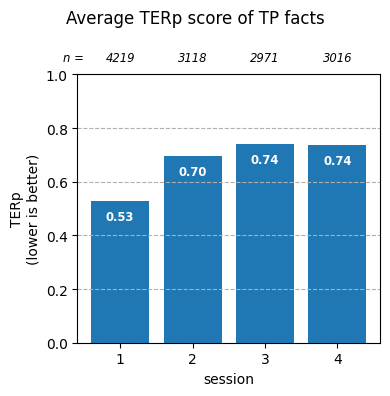

In [21]:
# TERp between prediction and target, average for all samples

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

terp_mean = df[selection["TP"]].groupby(['session'])['terp'].mean().values
terp_count =  df[selection["TP"]].groupby(['session'])['terp'].count().values

ax.bar(x=sessions, height=terp_mean)
for session, m in zip(sessions, terp_mean):
    ax.text(session, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
for session, t in zip(sessions, terp_count):
    ax.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("TERp\n(lower is better)")

fig.suptitle("Average TERp score of TP facts")
fig.tight_layout()

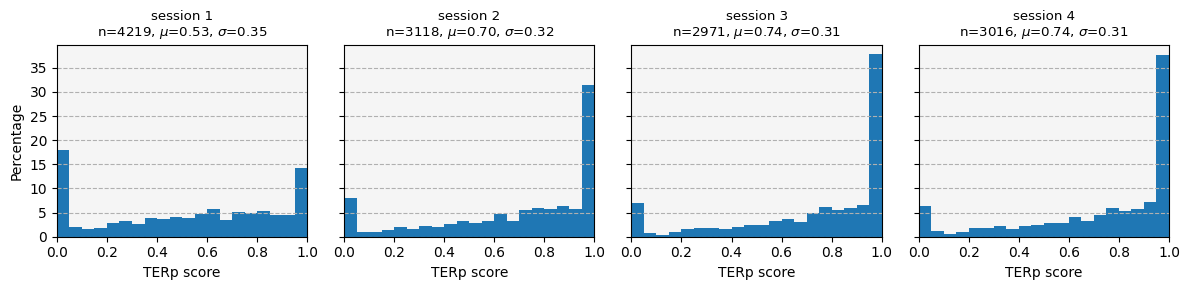

In [22]:
### ***THESIS*** Figure 4.7

# TERp between prediction and target, per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,3), sharey=True)

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip(sessions, axs):

        df_subset = df[selection["TP"] & (df['session'] == session)]['terp']
        terp_mean = df_subset.mean()
        terp_std = df_subset.std()
        terp_count =  df_subset.count()

        ax.hist(df_subset, bins=20, range=(0,1), density=True)

        ax.set_facecolor('whitesmoke')
        ax.set_title(f"session {session}\nn={terp_count}, " + r"$\mu$" + f"={terp_mean:.2f}, " + r"$\sigma$" + f"={terp_std:.2f}")
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xlim(0,1)
        ax.set_xlabel("TERp score")
        if session == 1:
            ax.set_yticks(np.array(range(11)))
            ax.set_yticklabels(np.array(range(11))*5)
            ax.set_ylabel("Percentage")

    # fig.suptitle("Distribution of TERp scores of TP facts")
    fig.tight_layout()
    plt.savefig('../docs/msc_turns_terp_per_session.pdf', dpi=300, format='pdf', bbox_inches='tight')

In [23]:
# Example of low TERp scores (low=good)
df.sort_values(by=['terp'])[['target_persona', 'pred_persona', 'terp']].head(10)

target_persona  \
1 468 6                         I have three kids.   
  173 10                 I just started a new job.   
3 389 10                         I play the flute.   
1 173 2   I was on the debate team in high school.   
  386 7                     I live near the beach.   
  172 6                             I have 2 kids.   
2 158 7                 I have a son and a sister.   
3 397 0                  I have a pet named Tasha.   
      1                      I only speak English.   
2 157 9            My last dog was a rescued mutt.   

                                      pred_persona  terp  
1 468 6                         I have three kids.   0.0  
  173 10                 I just started a new job.   0.0  
3 389 10                         I play the flute.   0.0  
1 173 2   I was on the debate team in high school.   0.0  
  386 7                     I live near the beach.   0.0  
  172 6                             I have 2 kids.   0.0  
2 158 7                 I have a son and a sister.   0.0  
3 397 0                  I have a pet named Tasha.   0.0  
      1                      I only speak English.   0.0  
2 157 9             My last dog was a rescue mutt.   0.0

In [24]:
# Example of high TERp scores (low=good)
df.sort_values(by=['terp'], ascending=False)[['target_persona', 'pred_persona', 'terp']].head(10)

target_persona  \
3 440 4                  I test items on my mother's menu.   
2 470 6  I don't have a gym membership. I go swimming o...   
  473 4                   I went skydiving in Napa Valley.   
      2  This was my first time skydiving, and I was sc...   
4 279 4  I think (speaker 1) should get a Lab. I think ...   
2 473 0  I have a gecko. I did not take my gecko skydiv...   
  472 9  I find the ocean peaceful and inspirational. I...   
1 339 5        I stay at home and attend college at devry.   
2 472 8       My mom's shop is a short walk from downtown.   
      4                         My mom owns a coffee shop.   

                                pred_persona  terp  
3 440 4  I am not creative. I enjoy cooking.   1.0  
2 470 6                 I do not swim often.   1.0  
  473 4       I was scared of landing badly.   1.0  
      2                      I have a gecko.   1.0  
4 279 4                        I have a Lab.   1.0  
2 473 0                     I have a lizard.   1.0  
  472 9                    I like the beach.   1.0  
1 339 5         I am studying online, devry.   1.0  
2 472 8                  I live in downtown.   1.0  
      4      I like pastries and sandwiches.   1.0

In [25]:
### ***THESIS*** Table 4.5

# Sample a number of TERp scores within a predefined range
# Translate the output to latex table

selection = (df['terp'] >= 0.95) & (df['session'] != 1) #& (df['terp'] <= 0.75) 
table_df = df[selection][['history', 'target_persona', 'pred_persona', 'terp']].sample(10).sort_values(by=['terp'])
table_df.set_index(['history'], inplace=True)  #['target_persona', 'pred_persona'],inplace=True)
s = table_df.style.format({
    'terp': '{:.2f}', 
})
print(s.to_latex(hrules=True, clines="all;data").replace('<sep>', '\\texttt{<sep>}'))
s

\begin{tabular}{lllr}
\toprule
 & target_persona & pred_persona & terp \\
history &  &  &  \\
\midrule
Yes, I will definitely go at least once. Hawaii is a great place to view fish in their natural habitat. I have saved enough money for some time under the water.\texttt{<sep>}I figured that you did. As you know, I'd love to go scuba diving some day, but I have to admit, seeing fish and other possibly scary things up close like that kind of freaks me out a little. lol! & I am a little scared by the idea of being up close with fish. I am interested in scuba diving. & I would love to go scuba diving. & 1.00 \\
\cline{1-4}
That would be great.  Pediatric nurses are in high demand.  I am sure you'll be awesome.\texttt{<sep>}Thank you I am just glad I can take night classes so that I can still work and pay by bills.  & I am taking night classes at my school and working during the days as a barista. & I can still work and pay by bills. & 1.00 \\
\cline{1-4}
Some real Italian pizza sounds deli

,target_persona,pred_persona,terp
history,,,
"Yes, I will definitely go at least once. Hawaii is a great place to view fish in their natural habitat. I have saved enough money for some time under the water.I figured that you did. As you know, I'd love to go scuba diving some day, but I have to admit, seeing fish and other possibly scary things up close like that kind of freaks me out a little. lol!",I am a little scared by the idea of being up close with fish. I am interested in scuba diving.,I would love to go scuba diving.,1.00
That would be great. Pediatric nurses are in high demand. I am sure you'll be awesome.Thank you I am just glad I can take night classes so that I can still work and pay by bills.,I am taking night classes at my school and working during the days as a barista.,I can still work and pay by bills.,1.00
"Some real Italian pizza sounds delicious. I love to look at the ancient sites and just ponder what all they've seen. Does your vivid imagination allow for time travel a well? That's gotta be real handy raising a little boy.It would be really cool to go back in time and see what the historical sites looked like when they were new, wouldn't it? Yes, it's a lot of fun to write stories with my son during playtime. Lately we've been pretending to be gladiators in Ancient Rome. But don't worry, I don't let it get too scary..",I play a game with my son about gladiators. I have a son. I write stories with my son.,I have a son.,1.00
Oh that would be interesting and fun. You right you never know. i see you said your your own boss. Is painting your full time job are do you own another business?My music composition is my main source of income. I work freelance and do different things like add piano to an existing song and sometimes I even get to compose a jingle for a commercial!,Most of them are music based. I have multiple avenues of revenue.,I work freelance. I am a composer.,1.00
"I guess that's the case with basically all the adoptions I can think of haha, the book will always have more details. Oh also I'm thinking of joining a book club lately!Does it meet online, or in person? I think the in-person ones sound really interesting, I just can never find the time with my job. I'm usually busy from early morning all the way into the evening.",I'm usually busy from early morning all the way into the evening. I jcan never find the time for book clubs with my job.,I work from early morning to evening.,1.00
"Shakshuka is one of my favorites, but I always love their shrimp pasta and the baked chicken drumsticks. There is just so many. I might try something new tonight.Hey, you can't go wrong with that approach! I need to be more adventuresome when I go out to eat. I usually just order the usual when I'm at my regular restaurants, but I think I'm missing out.",I usually order food that I am familiar with.,I like to eat at regular restaurants.,1.00
"I love getting to meet all the different people! What is your favorite part about your job?I love seeing the self-care and wellness of others. And yes, I agree. I love meeting new people. In fact, I am planning on taking my clients salsa dancing soon just for fun. Do you or your family do any type of dancing?",seeing the self-care and wellness of others Is my favorite part of my job.,I love meeting new people. I have a job.,1.00
"I see! How are the kids?They are doing great. Jennifer is doing really good in school. Brent just started baseball this spring and is really catching on fast, and Rob is really been a huge help at the farm. He gets up early to milk the cows several days a week to help me out. They all help, but he's been the most interested in farming.","My son, Brent, plays baseball. I have three children - two boys and a girl. My son, Rob, is interested in farming and helps out the most. My daughter, Jennifer, is a good student.",I have kids. I have a farm. My kids are doing well.,1.00
"That's a great idea! I hope you get in a couple long senic walks during this who

In [26]:
# Calculate what share of the samples has a TERp score within a predefined range

selection = (df['terp'] >= 0) & (df['terp'] <= 0.75) & (df['session'] == 1)
good_terp = df[selection]['terp'].count()
total = df[(df['terp'] >= 0)  & (df['session'] == 1)]['terp'].count()
print(good_terp, total, good_terp/total)


2809 4219 0.6657975823654895


### NLI-score

In [27]:
print(f"NLI prediction to target : {df[(df['pred_fact'] == 1) & (df['target_fact'] == 1) ]['nli_pred_to_target'].mean():.4f}")
print(f"NLI input to prediction  : {df[df['pred_fact'] == 1]['nli_pred'].mean():.4f}")

NLI prediction to target : 0.3683
NLI input to prediction  : 0.7800


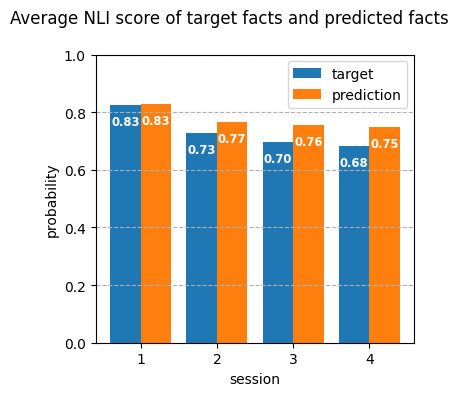

In [28]:
# All NLI scores from input to target, input to prediction; per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, ax = plt.subplots(figsize=(4,4))

nli_target_mean = df[df['target_fact'] == 1].groupby(['session'])['nli_target'].mean().values
nli_pred_mean = df[df['pred_fact'] == 1].groupby(['session'])['nli_pred'].mean().values

ax.bar(x=sessions - 0.2, height=nli_target_mean, width=0.4, label="target")
ax.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, label="prediction")
for session, m in zip(sessions, nli_target_mean):
    ax.text(session - 0.2, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
for session, m in zip(sessions, nli_pred_mean):
    ax.text(session + 0.2, m - 0.07, f"{m:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

ax.legend()
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xticks(sessions)
ax.set_xlabel("session")
ax.set_ylim(0,1)
ax.set_ylabel("probability")

fig.suptitle("Average NLI score of target facts and predicted facts")
fig.tight_layout()

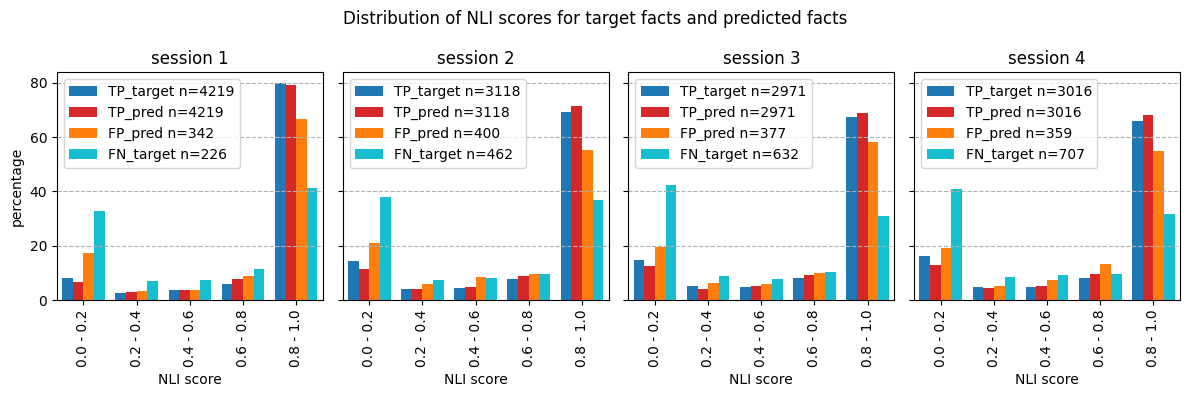

In [29]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 0.2, 0.4, 0.6, 0.8, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    for i, s in enumerate(colors.keys()):
        df_subset = df[selection[s[:2]] & (df['session'] == session)]
        nli_col = 'nli' + s[2:]
        num_perbin = np.array([
            df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
            for lower, upper in bins
        ])
        num_total =  sum(num_perbin)

        ax.bar(x=x_range+0.2+i*0.2, height=num_perbin/num_total*100, color=colors[s], width=0.2, label=f"{s} n={num_total}")

    ax.set_title(f"session {session}")
    ax.legend()
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0, len(bins))
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks(x_range + 0.5)
    ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    ax.set_xlabel("NLI score")
    if session == 1:
        # ax.set_yticks(np.array(range(21)))
        # ax.set_yticklabels(np.array(range(21))*2)
        ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

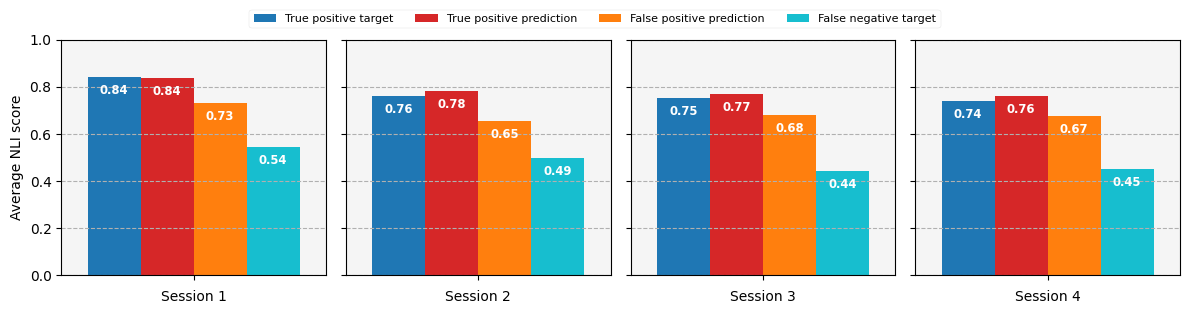

In [30]:
### ***THESIS*** Figure 4.8

# NLI scores for the four classification categories; per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,3), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
labels = {
    "TP_target": "True positive target",
    "TP_pred": "True positive prediction",
    "FP_pred": "False positive prediction", 
    "FN_target": "False negative target",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

with plt.style.context('seaborn-v0_8-paper'):
    for session, ax in zip(sessions, axs):

        for i, s in enumerate(colors.keys()):
            df_subset = df[selection[s[:2]] & (df['session'] == session)]
            nli_col = 'nli' + s[2:]
            avg_perbin = np.array([
                df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].mean()
                for lower, upper in bins
            ])
            std_perbin = np.array([
                df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].std()
                for lower, upper in bins
            ])
            x_range_bin = x_range+0.2+i*0.2
            ax.bar(x=x_range_bin, height=avg_perbin, 
                #    yerr=std_perbin, 
                color=colors[s], width=0.2, label=f"{labels[s]}")
            ax.text(x_range_bin[0], avg_perbin - 0.07, f"{avg_perbin[0]:.2f}", horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

        ax.set_facecolor('whitesmoke')
        ax.set_xlabel(f"Session {session}")
        ax.grid(which='major', axis='y', linestyle='--')
        ax.set_xlim(0, len(bins))
        ax.set_xticks(x_range + 0.5)
        ax.set_xticklabels("")
        if session == 1:
            ax.set_ylim(0,1)
            ax.set_ylabel("Average NLI score")

    # fig.suptitle("Average NLI scores for target facts and predicted facts, per session")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
    fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05), ncols=4)
    fig.tight_layout()
    plt.savefig('../docs/msc_turns_nli_per_session.pdf', dpi=300, format='pdf', bbox_inches='tight')

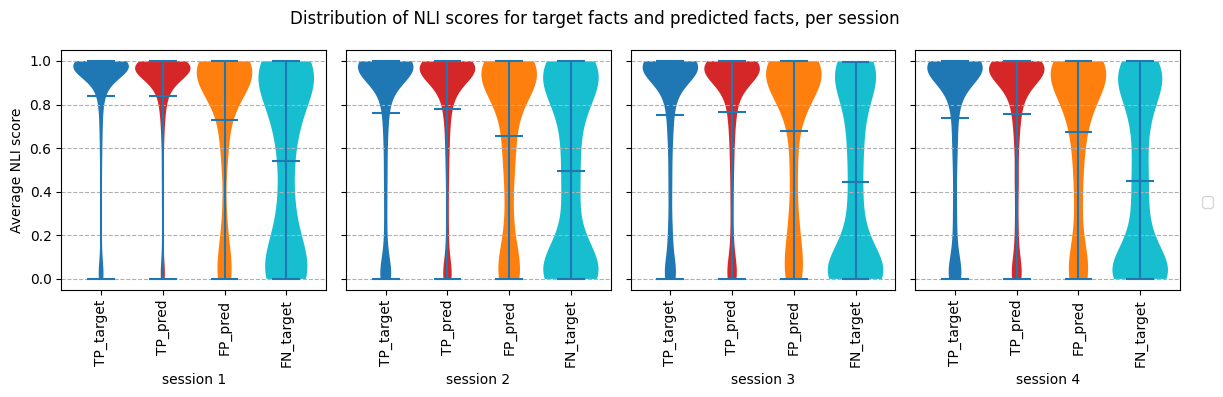

In [31]:
# Violinplot with NLI scores per category, per session

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}

bin_boundaries = [0, 1.01]
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    data = [
        df[selection[s[:2]] & (df['session'] == session)]['nli' + s[2:]].values
        for s in colors.keys()
    ]

    plots = ax.violinplot(data, showmeans=True, widths=0.9)

    for pc, color in zip(plots['bodies'], colors.values()):
        pc.set_facecolor(color)
        pc.set_alpha(1)
    ax.set_xlabel(f"session {session}")
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(colors.keys())
    ax.grid(which='major', axis='y', linestyle='--')
    if session == 1:
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel("Average NLI score")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts, per session")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

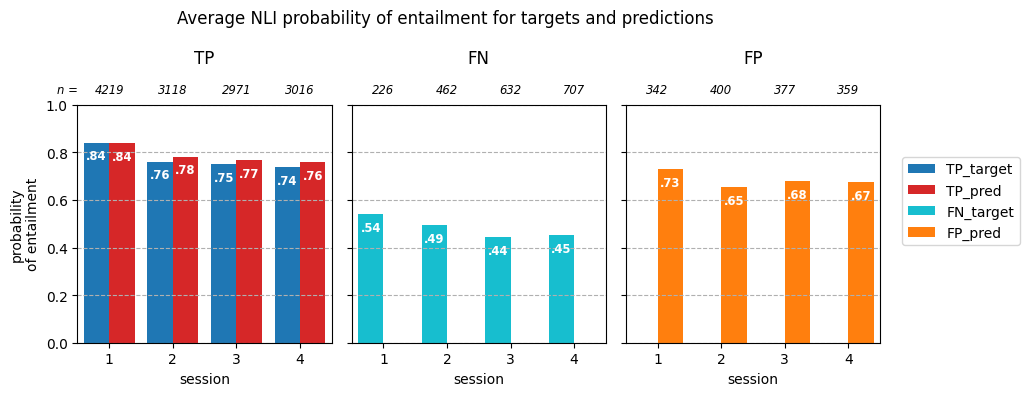

In [32]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)
colors = {
    "TP_target": "tab:blue",
    "TP_pred": "tab:red",
    "FP_pred": "tab:orange", 
    "FN_target": "tab:cyan",
}
fig, ax = plt.subplots(ncols=3, figsize=(9,4), sharey=True)

for s, a in zip(["TP", "FN", "FP"], ax):

    if s == 'TP' or s == 'FN':
        nli_tgt_mean = df[selection[s]].groupby(['session'])['nli_target'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_target'].count().values
        a.bar(x=sessions - 0.2, height=nli_tgt_mean, width=0.4, color=colors[f"{s}_target"], label=f"{s}_target")
        for session, m in zip(sessions, nli_tgt_mean):
            a.text(session - 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')
    if s == 'TP' or s == 'FP':
        nli_pred_mean = df[selection[s]].groupby(['session'])['nli_pred'].mean().values
        count = df[selection[s]].groupby(['session'])['nli_pred'].count().values
        a.bar(x=sessions + 0.2, height=nli_pred_mean, width=0.4, color=colors[f"{s}_pred"], label=f"{s}_pred")
        for session, m in zip(sessions, nli_pred_mean):
            a.text(session + 0.2, m - 0.07, (f"{m:.2f}")[1:], horizontalalignment='center', fontweight='bold', fontsize='small', c='w')

    for session, t in zip(sessions, count):
        a.text(session, 1.05, t, horizontalalignment='center', fontsize='small', fontstyle='italic')
    a.set_title(s, pad=30)
    a.grid(which='major', axis='y', linestyle='--')
    a.set_xlim(0.5, 4.5)
    a.set_xticks(sessions)
    a.set_xlabel("session")
    if s == "TP":
        a.text(0.5, 1.05, "n =", horizontalalignment='right', fontsize='small', fontstyle='italic')
        a.set_ylabel("probability\nof entailment")
        a.set_ylim(0, 1)
    
fig.suptitle("Average NLI probability of entailment for targets and predictions")
# handles, labels = ax[0].get_legend_handles_labels()
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

### Correlation NLI-score and TERp

1 [0.64296463 0.69781351 0.5723348  0.65578539 0.63754421 0.58363002
 0.52695144 0.58522155 0.49454601 0.50792752] [ 214   68   56   64   81   71  122  208  487 2848]
2 [0.79818351 0.79123832 0.75256716 0.80984155 0.66848362 0.71431465
 0.75031802 0.72573565 0.68300865 0.66736991] [ 294   60   64   59   64   81  106  168  340 1882]
3 [0.84064452 0.80138117 0.79267794 0.78903731 0.80532606 0.79782073
 0.77650552 0.75564845 0.75251534 0.70321962] [ 294   81   58   63   65   86  107  171  313 1733]
4 [0.83259861 0.80332711 0.81853591 0.77635286 0.8178193  0.74614153
 0.74446608 0.78506336 0.73157532 0.69957755] [ 306   86   72   62   87   64  104  183  336 1716]


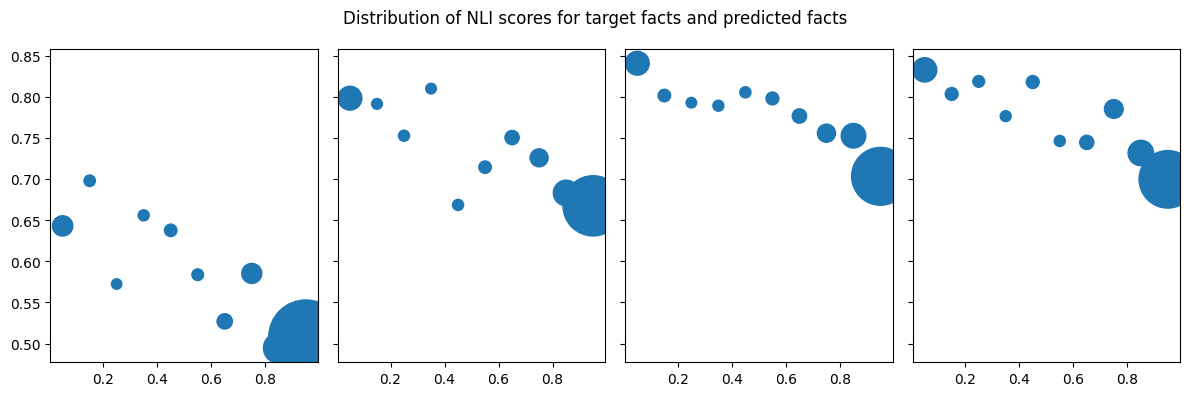

In [33]:
# relation between NLI score and TERp score

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

bin_boundaries = np.linspace(0, 1.0, num=11)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]
x_range = np.arange(len(bins))

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    nli_col = 'nli_pred'
    num_perbin = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
        for lower, upper in bins
    ])
    num_total = sum(num_perbin)
    avg_terp = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].mean()
        for lower, upper in bins
    ])
    print(session, avg_terp, num_perbin)

    ax.scatter(bin_boundaries[:-1] + 0.05, avg_terp, s=num_perbin)

    # ax.set_title(f"session {session}")
    # ax.legend()
    # ax.grid(which='major', axis='y', linestyle='--')
    # ax.set_xlim(0, len(bins))
    # ax.tick_params(axis='x', labelrotation = 90)
    # ax.set_xticks(x_range + 0.5)
    # ax.set_xticklabels(f"{lower:.1f} - {upper:.1f}" for lower, upper in bins)
    # ax.set_xlabel("NLI score")
    # if session == 1:
    #     # ax.set_yticks(np.array(range(21)))
    #     # ax.set_yticklabels(np.array(range(21))*2)
    #     ax.set_ylabel("percentage")

fig.suptitle("Distribution of NLI scores for target facts and predicted facts")
fig.tight_layout()

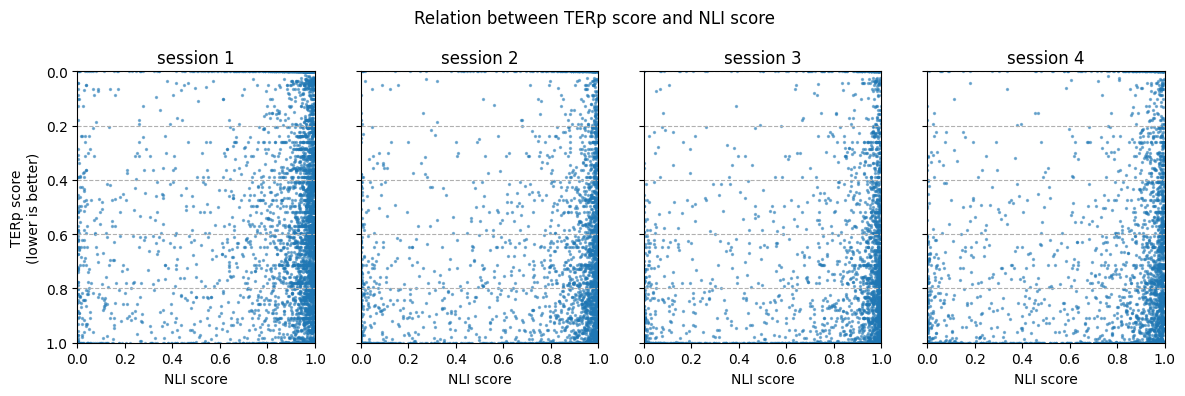

In [34]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

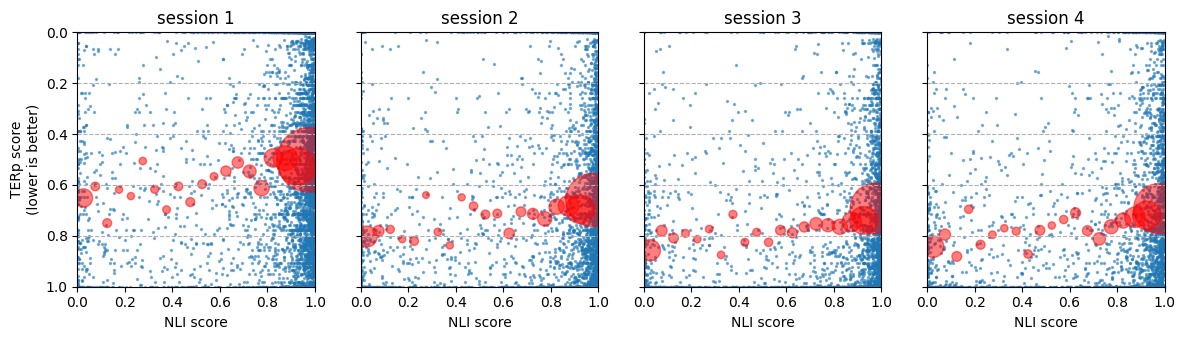

In [35]:
### ***THESIS*** Figure 4.9

sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.0, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,3.5), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)

    # Calculate average per 'bin' and add it to scatter chart
    nli_col = 'nli_pred'
    num_perbin = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)][nli_col].count()
        for lower, upper in bins
    ])
    avg_terp = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].mean()
        for lower, upper in bins
    ])
    ax.scatter(bin_boundaries[:-1] + 0.5/num_bins, avg_terp, s=num_perbin, c='r', alpha=0.5)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

# fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()
plt.savefig('../docs/msc_turns_nli_terp.pdf', dpi=300, format='pdf', bbox_inches='tight')

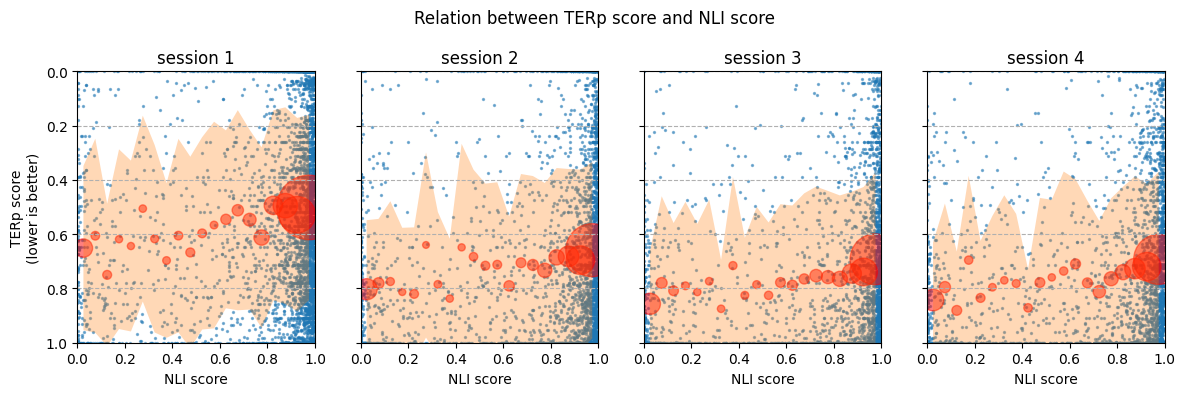

In [36]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.0, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)
    corr = df_subset[['nli_pred', 'terp']].corr().values[0,1]
    # print(corr)
    
    # Calculate average per 'bin' and add it to scatter chart
    terp_data = np.array([
        df_subset[(df_subset[nli_col] >= lower) & (df_subset[nli_col] < upper)]['terp'].agg(['mean', 'std', 'count'])
        for lower, upper in bins
    ])
    ax.scatter(bin_boundaries[:-1] + 0.5/num_bins, terp_data[:, 0], s=terp_data[:, 2], c='r', alpha=0.5)
    ax.fill_between(bin_boundaries[:-1] + 0.5/num_bins, y1=terp_data[:, 0] - terp_data[:, 1], y2=terp_data[:, 0] + terp_data[:, 1], alpha=0.3)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()

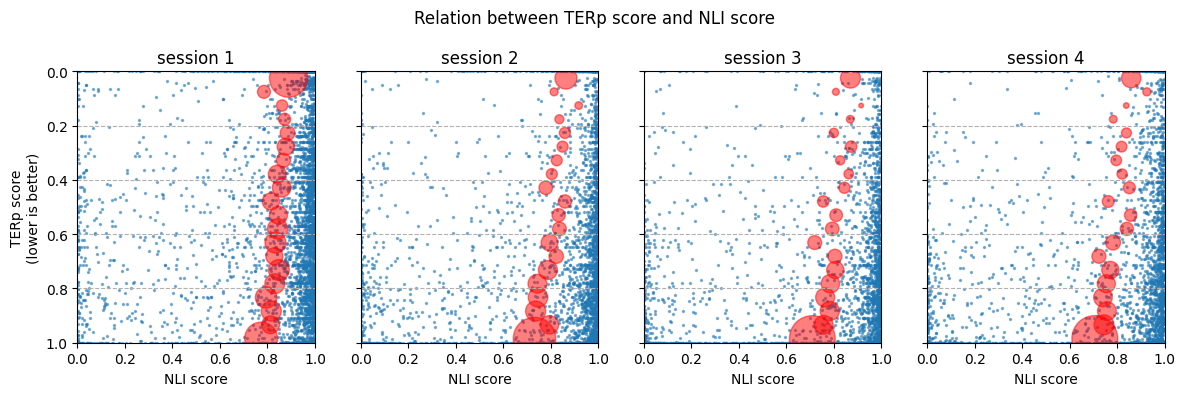

In [37]:
sessions = df['session'].unique()

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

num_bins = 20
bin_boundaries = np.linspace(0, 1.01, num=num_bins+1)
bins = [(lower, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

fig, axs = plt.subplots(ncols=len(sessions), figsize=(12,4), sharey=True)

for session, ax in zip(sessions, axs):

    df_subset = df[selection["TP"] & (df['session'] == session)]
    terp_count =  df_subset.count()

    ax.scatter(df_subset['nli_pred'], df_subset['terp'], alpha=0.5, s=2)
    corr = df_subset[['nli_pred', 'terp']].corr().values[0,1]
    # print(corr)
    
    # Calculate average per 'bin' and add it to scatter chart
    nli_data = np.array([
        df_subset[(df_subset['terp'] >= lower) & (df_subset['terp'] < upper)][nli_col].agg(['mean', 'std', 'count'])
        for lower, upper in bins
    ])
    ax.scatter(nli_data[:, 0], bin_boundaries[:-1] + 0.5/num_bins,  s=nli_data[:, 2], c='r', alpha=0.5)
    # ax.fill_between(bin_boundaries[:-1] + 0.5/num_bins, y1=terp_data[:, 0] - terp_data[:, 1], y2=terp_data[:, 0] + terp_data[:, 1], alpha=0.3)

    ax.set_title(f"session {session}")
    ax.grid(which='major', axis='y', linestyle='--')
    ax.set_xlim(0,1)
    ax.set_xlabel("NLI score")
    if session == 1:
        ax.set_ylim(1,0)
        ax.set_ylabel("TERp score\n(lower is better)")

fig.suptitle("Relation between TERp score and NLI score")
fig.tight_layout()
plt.savefig('../docs/msc_turns_terp_nli.pdf', dpi=300, format='pdf', bbox_inches='tight')

## Take sample from dataset for analysis

In [38]:
max_inputwords = df['inputwords'].max()
bin_boundaries = [0, 10, 20, 30, 40, 50, 60, 80, 100, max_inputwords]
bins = [(lower + 1, upper) for lower, upper in zip(bin_boundaries[:-1], bin_boundaries[1:])]

selection = {}
selection["TP"] = (df['target_fact'] == 1) & (df['pred_fact'] == 1)
selection["TN"] = (df['target_fact'] == 0) & (df['pred_fact'] == 0)
selection["FP"] = (df['target_fact'] == 0) & (df['pred_fact'] == 1)
selection["FN"] = (df['target_fact'] == 1) & (df['pred_fact'] == 0)

samples = []
for s in selection.keys():
    for lower, upper in bins:
        subset = (selection[s] & (df['inputwords'] >= lower) & (df['inputwords'] <= upper))
        samples.append(df[subset].sample(n=min(10, len(df[subset])), axis=0, replace=False, ignore_index=False).index)

sampled = pd.MultiIndex.from_tuples([id for indexlist in samples for id in indexlist])
sampled

MultiIndex([(1, 311,  6),
            (1, 356,  8),
            (1, 445,  3),
            (1, 455,  9),
            (1,  86,  0),
            (1, 431,  4),
            (1, 473,  0),
            (1,  35,  0),
            (1, 424,  0),
            (1, 117,  0),
            ...
            (4, 448,  9),
            (3,   3,  9),
            (4, 301, 10),
            (4, 104, 10),
            (3, 495,  7),
            (4, 262,  4),
            (4, 210,  3),
            (2, 425,  3),
            (3, 254,  6),
            (4,  23,  4)],
           length=345)

In [39]:
# Define whether to save a random sample or load existing sample and save it with updated info
ACTION = ''
# ACTION = 'update'
# ACTION = 'save'

In [40]:
if ACTION == 'save':
    output_dir = "/Users/FrankVerhoef/Programming/PEX/output/"
    filename = "sample_newnli.csv"
    df.loc[sampled].to_csv(output_dir + filename, sep='\t') 

In [41]:
# Load the saved csv file (with additional columns)
if ACTION == 'update':
    df_index = pd.read_csv(output_dir + "sample_index.csv", sep=';')

    # Extract the index
    sampled_index = pd.MultiIndex.from_arrays(df_index[['i0', 'i1', 'i2']].values.T)

    # Save specified columns
    df.loc[sampled_index][['nli_pred', 'nli_target']].to_csv(output_dir + 'new_nli.csv', sep='\t') 

In [42]:
df.loc[(4,258,4)]['history']

"I'm beginning to enjoy the great outdoors much more than I did when I was younger; I do like city breaks but every now and then it's great to be out in the fresh air with stunning views. The Big Sur is meant to be a beautiful place, I hope you are able to go. I've never actually been to California before!<sep>I really hope so too - I'd book it right away if I had the money! It's a long story but I've had trouble finding work lately. I'm okay for money but I'm saving up for my dream car so I have to balance that with potential trips! You'd love California, maybe we can go there together sometime if you can get the time off work!"